# Feature engineering

After removal of anomalies and imputation of missing values, we can begin analyzing the dataset itself

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from pm25_hyperparameters import *

DATASET_PATH="BeijingPM_imputed.csv"

data=pd.read_csv(DATASET_PATH)
data.index=pd.DatetimeIndex(data["date"])
data.head()

,id,year,month,day,hour,season,PM,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,date
date,,,,,,,,,,,,,,,
2010-01-01 00:00:00,0,2010,1,1,0,4,129.0,-21.0,43.0,1021.0,-11.0,1,1.79,0.0,2010-01-01 00:00:00
2010-01-01 01:00:00,1,2010,1,1,1,4,129.0,-21.0,47.0,1020.0,-12.0,1,4.92,0.0,2010-01-01 01:00:00
2010-01-01 02:00:00,2,2010,1,1,2,4,129.0,-21.0,43.0,1019.0,-11.0,1,6.71,0.0,2010-01-01 02:00:00
2010-01-01 03:00:00,3,2010,1,1,3,4,129.0,-21.0,55.0,1019.0,-14.0,1,9.84,0.0,2010-01-01 03:00:00
2010-01-01 04:00:00,4,2010,1,1,4,4,129.0,-20.0,51.0,1018.0,-12.0,1,12.97,0.0,2010-01-01 04:00:00


## Holiday and special event features

We used the open-source package [`chinese-calendar`][1] to generate attribute `is_holiday`. We also used manually collected dataset to generate `is_special_event`.

[1]: https://github.com/LKI/chinese-calendar

In [2]:
from datetime import date
from chinese_calendar import is_holiday

datetime_filename="BeijingPM_datetime.csv"

if os.path.exists(datetime_filename):
    print("Reading existing features from %s" % datetime_filename)
    datetime_fea=pd.read_csv(datetime_filename)
    datetime_fea.index=pd.DatetimeIndex(datetime_fea["date"])
    datetime_fea.drop("date",axis=1,inplace=True)
else:
    sedf=pd.read_csv("Beijing_events.csv")
    sedf["date0"]=pd.to_datetime(sedf["date0"])
    sedf["date1"]=pd.to_datetime(sedf["date1"])

    def gen_datetime_features(row):
        dt=date(year=row["year"],month=row["month"],day=row["day"])
        row["is_holiday"]=int(is_holiday(dt))
        row["is_special_event"]=sedf[(sedf["date0"]<=row["date"]) & (row["date"]<=sedf["date1"])].shape[0]
        return row[["is_holiday","is_special_event"]]

    tqdm.pandas(desc="Generating datetime features")
    datetime_fea=data.progress_apply(gen_datetime_features,axis=1)
    datetime_fea.to_csv(datetime_filename)

datetime_fea[::24].head()

Reading existing features from BeijingPM_datetime.csv


,is_holiday,is_special_event
date,,
2010-01-01,1,0
2010-01-02,1,0
2010-01-03,1,0
2010-01-04,0,0
2010-01-05,0,0


## Lagged features

In this section, we generate features from original attributes of our dataset via sliding window mechanism. Specifically, we incorporate metereological parameters from the past `lag_hours` hours into each entry.

In [3]:
lagged_filename="BeijingPM_lagged.csv"

if os.path.exists(lagged_filename):
    print("Reading existing features from %s" % lagged_filename)
    lagged=pd.read_csv(lagged_filename)
    lagged.index=pd.DatetimeIndex(lagged["date"])
    lagged.drop("date",axis=1,inplace=True)
else:
    print("Generating lagged features")
    df_list = []
    for lag in range(1,lag_hours+1):
        df_shifted = data[prim_fea].shift(lag)
        df_shifted.columns = [x + "_lag" + str(lag) for x in df_shifted.columns]
        df_list.append(df_shifted)
    lagged = pd.concat(df_list, axis=1)
    lagged.to_csv(lagged_filename)

lagged[::24].head()

Reading existing features from BeijingPM_lagged.csv


,TEMP_lag1,DEWP_lag1,HUMI_lag1,PRES_lag1,precipitation_lag1,Iws_lag1,PM_lag1,TEMP_lag2,DEWP_lag2,HUMI_lag2,...,precipitation_lag47,Iws_lag47,PM_lag47,TEMP_lag48,DEWP_lag48,HUMI_lag48,PRES_lag48,precipitation_lag48,Iws_lag48,PM_lag48
date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-02,-5.0,-17.0,41.0,1020.0,0.0,0.89,129.0,-5.0,-17.0,38.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,-6.0,-8.0,85.0,1027.0,0.0,55.43,90.0,-6.0,-8.0,85.0,...,0.0,4.92,129.0,-11.0,-21.0,43.0,1021.0,0.0,1.79,129.0
2010-01-04,-11.0,-12.0,92.0,1023.0,0.0,14.30,79.0,-9.0,-11.0,85.0,...,0.0,2.68,159.0,-4.0,-16.0,38.0,1020.0,0.0,1.79,148.0
2010-01-05,-15.0,-26.0,38.0,1035.0,0.0,198.45,30.0,-13.0,-24.0,39.0,...,0.5,61.69,65.0,-6.0,-7.0,92.0,1027.0,0.4,58.56,63.0


### Statistics over rolling window

In this section, we extract local minima, local maxima, and mean from rolling window.

In [4]:
stats_filename="BeijingPM_stats.csv"

if os.path.exists(stats_filename):
    print("Reading existing features from %s" % stats_filename)
    stats=pd.read_csv("BeijingPM_stats.csv")
    stats.index=pd.DatetimeIndex(stats["date"])
    stats.drop("date",axis=1,inplace=True)
else:
    print("Generating statistical features")
    rl=data[prim_fea].rolling(window=stat_wnd)
    stats=pd.concat([rl.mean().rename(lambda x:x+"_mean",axis="columns"),
                     rl.max().rename(lambda x:x+"_max",axis="columns"),
                     rl.min().rename(lambda x:x+"_min",axis="columns")],axis=1)
    stats.to_csv(stats_filename)

stats[::24].head()

Reading existing features from BeijingPM_stats.csv


,TEMP_mean,DEWP_mean,HUMI_mean,PRES_mean,precipitation_mean,Iws_mean,PM_mean,TEMP_max,DEWP_max,HUMI_max,...,precipitation_max,Iws_max,PM_max,TEMP_min,DEWP_min,HUMI_min,PRES_min,precipitation_min,Iws_min,PM_min
date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,-5.833333,-13.333333,59.218750,1021.041667,0.008333,20.841875,135.291667,-1.0,-7.0,92.0,...,0.4,58.56,181.0,-14.0,-21.0,25.0,1014.0,0.0,0.89,63.0
2010-01-04,-7.000000,-9.270833,83.906250,1023.833333,0.233333,48.196875,109.479167,-4.0,-7.0,92.0,...,1.2,127.84,181.0,-12.0,-15.0,42.0,1020.0,0.0,0.89,53.0
2010-01-05,-10.250000,-15.895833,66.083333,1026.208333,0.225000,94.028958,53.229167,-6.0,-8.0,92.0,...,1.2,201.58,107.0,-17.0,-26.0,36.0,1020.0,0.0,0.89,20.0


## Features from `PM`'s frequency domain

Time series can often be decomposed into trend and seasonality, so we perform short-time Fourier transform on the PM2.5 series.

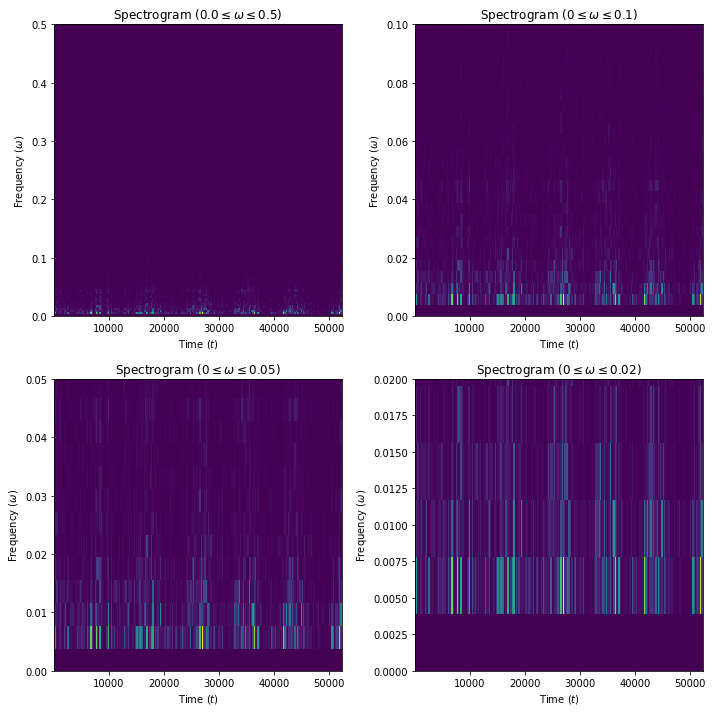

In [5]:
from scipy import signal

_f,t,sxx=signal.spectrogram(data["PM"],window="boxcar",nperseg=256)
fg=plt.figure(figsize=(10,10))
fg.set_tight_layout(True)

def plot_spectrogram(ax,f,t,sxx,fmin=-1,fmax=-1):
    ax.pcolormesh(t,f,sxx)
    ax.set_xlabel("Time ($t$)")
    ax.set_ylabel(r"Frequency ($\omega$)")
    if fmin>=0 and fmax>=0:
        ax.set_ylim(fmin,fmax)
    else:
        fmin,fmax=ax.get_ylim()
    ax.set_title(r"Spectrogram (${}\leq\omega\leq{}$)".format(fmin,fmax))
    return ax

(ax,ax2),(ax3,ax4)=fg.subplots(2,2)
plot_spectrogram(ax,_f,t,sxx)
plot_spectrogram(ax2,_f,t,sxx,0,0.1)
plot_spectrogram(ax3,_f,t,sxx,0,0.05)
plot_spectrogram(ax4,_f,t,sxx,0,0.02)

plt.savefig("graphs/spectrogram.png")

Based on the above comparisons, we discover that the Fourier coefficients for frequencies such that $0\leq\omega\leq0.02$ are more significant than those of other frequencies, so we will only store the Fourier coefficients in that frequency interval to the dataset.

In [6]:
stft_filename="BeijingPM_stft.csv"
if os.path.exists(stft_filename):
    print("Reading existing features from %s" % stft_filename)
    pm_stft=pd.read_csv(stft_filename)
    pm_stft.index=pd.DatetimeIndex(pm_stft["date"])
    pm_stft.drop("date",axis=1,inplace=True)
else:
    print("Generating frequency-domain features")
    stft_index=list(data.loc[data["id"]>=stft_period,"date"])
    f,t,stft=signal.stft(data["PM"],window="boxcar",nperseg=stft_period,
                         noverlap=stft_period-1,boundary=None,padded=False)
    stft_coeffs=np.abs(stft[f<=stft_upper]).T[:-1]

    stft_cols=["stft_%d" % m for m in range(stft_coeffs.shape[1])]
    pm_stft=pd.DataFrame(stft_coeffs,columns=stft_cols)
    pm_stft["date"]=stft_index
    pm_stft.index=pd.DatetimeIndex(pm_stft["date"])
    pm_stft.drop("date",axis=1,inplace=True)
    pm_stft.to_csv(stft_filename)

pm_stft[::24]

Reading existing features from BeijingPM_stft.csv


,stft_0,stft_1,stft_2,stft_3,stft_4,stft_5,stft_6,stft_7,stft_8,stft_9,...,stft_125,stft_126,stft_127,stft_128,stft_129,stft_130,stft_131,stft_132,stft_133,stft_134
date,,,,,,,,,,,,,,,,,,,,,
2010-01-29,93.976190,16.758337,24.855954,33.738768,9.682404,19.203026,8.148744,9.735022,14.879033,6.058545,...,1.197717,0.841096,0.669159,1.461749,1.248827,1.037334,1.355093,0.440955,1.046557,0.861513
2010-01-30,90.284226,19.582026,23.528091,32.704434,12.685932,18.362866,11.384585,11.854666,13.777843,3.345975,...,1.197447,0.822349,0.820258,1.283175,1.303852,1.121831,1.312683,0.570907,1.015920,0.831692
2010-01-31,86.747024,22.865364,21.285181,34.338648,13.708756,15.143763,13.311499,9.828546,11.056826,3.931810,...,1.155313,0.847114,0.666774,1.477420,1.143638,1.189890,1.151682,0.457601,1.252122,0.593055
2010-02-01,85.319940,24.275830,20.090105,35.618984,13.301923,13.993034,12.790457,8.493307,11.888127,5.043548,...,1.150959,0.893489,0.740933,1.470793,1.162463,1.183014,1.125473,0.481120,1.245927,0.634673
2010-02-02,86.583333,23.022902,21.338873,34.444698,14.470769,13.611003,13.918821,7.924493,11.469088,6.068044,...,1.255865,0.873471,0.867190,1.403744,1.262079,1.105403,1.126400,0.448198,1.352874,0.589729
2010-02-03,87.382440,22.257658,22.109331,33.920913,15.201408,12.910137,14.167780,7.160297,12.111023,6.335689,...,1.183606,0.756186,0.748053,1.264119,1.397211,0.908167,1.330254,0.293749,1.568270,0.501072
2010-02-04,88.081845,21.638596,22.686014,33.826953,15.520841,12.256631,13.609759,7.123741,12.520976,5.503400,...,1.211888,0.865698,0.766013,1.413530,1.236022,1.060840,1.322501,0.219968,1.526478,0.318109
2010-02-05,87.501488,21.972225,22.686547,33.234033,16.154276,11.618695,13.383922,7.139839,12.704689,4.828168,...,1.357513,0.688219,0.928412,1.374144,1.236351,1.114146,1.251949,0.279845,1.470821,0.387507
2010-02-06,84.081845,23.879053,23.579565,29.883104,19.389191,8.456913,10.958005,9.698488,11.031621,6.086774,...,0.854289,0.729515,0.826604,0.880461,1.696915,1.093196,0.848682,0.685172,1.102049,0.456180


## Feature fusion

In this section, we gather the original dataset, lagged features, and statistical features to form a new dataset used for our research. We put frequency-domain features into a separate file for control experiments.

In [7]:
# Combine everything except frequency-domain features
dataset=pd.concat([data,datetime_fea,lagged,stats],axis=1)

# Strip missing values from the dataset
tqdm.pandas(desc="(0/2) Stripping missing values")
first=dataset.progress_apply(lambda s:s.first_valid_index(),axis=0).max()

data_file="BeijingPM_dataset.csv"
print("(1/2) Writing dataset to %s" % data_file)
dataset_final=dataset[dataset["date"]>=str(first)]
dataset_final.drop(["id","date"],axis=1).to_csv(data_file)

print("(2/2) OK")

/usr/local/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
(0/2) Stripping missing values: 100%|██████████| 374/374 [00:02<00:00, 155.75it/s]


(1/2) Writing dataset to BeijingPM_dataset.csv
(2/2) OK
